In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This sets all the initial variables

In [2]:
df = pd.read_parquet('BOQ_data.parquet')
df['PRC'] = df['PRC'].ffill().bfill()
df['pm'] = df['pm'].ffill().bfill()
df['RET'] = df['RET'].ffill().bfill()
start = min(df['DATE'])
dates = df['DATE'].unique()
data = {}
dates = sorted(dates)

In [19]:
data = {}

BIG LOOP

In [3]:
currAccValue = 0
AccValues = []
positions = {}
Pnl = []
# perm: num of stocks bought
cash = 10000
def calc_leverage():
    leveraged = 0
    for key,val in positions.items():
        if val<0:
            leveraged = data[key]['price'][-1]*val
    return leveraged
def calc_acc_value():
    acc_value = 0
    for key,val in positions.items():
        acc_value += data[key]['price'][-1]*val
    acc_value+=cash
    return acc_value

for date in dates:
    buy = []
    sell = []
    #lists for holding the permnos of the companies that we will buy and sell
    currMonthData = df[df['DATE'] == date]
    for perm in currMonthData.values:
        name = f'{perm[18]}'
        price = perm[19]
        profm = perm[65]
        ret = perm[21]
        if data.get(name):
            #updating our own metrics for each company
            curr = data[name]
            curr['price'].append(price)
            curr['profm'].append(profm)
            curr['ret'].append(ret)
            curr['month change'] = price/curr['price'][-2] -1
            if len(curr['price']) > 3:
                curr['3month change'] = price/curr['price'][-4] - 1
                if len(curr['price']) > 6:
                    curr['6month change'] = price/curr['price'][-7] - 1
            #adding to buy or sell if hitting certain signals
            if (curr['month change'] < 0):
                buy.append(name)
            elif (curr['month change'] > 0):
                sell.append(name)
        else:
            data[name] = {'price':[price],'profm':[profm],'ret':[ret]}
    # buying and selling the permnos in the lists made from each iteration
    for per in sell:
        price = data[per]['price'][-1]
        if positions.get(per):
            if positions[per]>0:
                cash += price*positions[per]
                positions[per] = 0
    for per in buy:
        price = data[per]['price'][-1]
        if cash > price :
            if positions.get(per):
                positions[per] += 1
                cash-= price
            else:
                positions[per] = 1
                cash -= price
    # gets the current value of all the positions after each iteration on the dates
    acc_val = calc_acc_value()
    AccValues.append(acc_val)
    Pnl.append(acc_val-10000)

get the column index for a identifier

In [7]:
cols = df.columns.values
inp = input(f'{cols}   which name?')
def get_index(name):
    count = 0
    it = iter(cols)
    while name!=next(it):
        count+=1
        if count == 85:
            count+=1
            break
    return count
print(get_index(inp))

21


In [4]:
returns = np.diff(AccValues) / AccValues[:-1]
mean_return = np.mean(returns)
std_dev = np.std(returns)
sharpe_ratio = (mean_return - 0.03 / 12) / std_dev
sharpe_ratio

0.04363699719668649

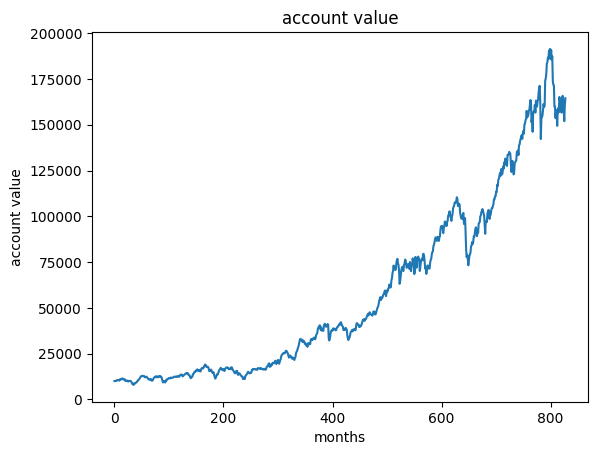

22.391660704356006

In [11]:
plt.plot(np.arange(len(AccValues)),AccValues)
plt.xlabel('months')
plt.ylabel('account value')
plt.title('account value')
plt.show()
(AccValues[-1]/10000 -1)*100/len(AccValues)*12

In [10]:
AccValues

[10000,
 10000.0,
 10003.5625,
 10248.1875,
 10149.875,
 10439.5,
 10493.875,
 10595.125,
 10462.875,
 10203.125,
 10926.625,
 11026.625,
 10857.1875,
 11013.125,
 11441.0,
 11329.625,
 10830.375,
 10905.9375,
 11062.3125,
 10924.3125,
 10068.6875,
 10096.4375,
 10011.25,
 10256.75,
 10281.625,
 9708.5625,
 9905.3125,
 10052.25,
 10120.4375,
 10021.1875,
 10001.25,
 9517.0,
 8882.375,
 8303.5,
 8442.5,
 7878.6875,
 8749.1875,
 8501.25,
 8731.125,
 8885.25,
 9145.5625,
 9454.5625,
 10020.125,
 10187.75,
 10656.6875,
 10892.9375,
 11282.5625,
 11749.875,
 12349.75,
 12649.5625,
 12661.0625,
 12892.875,
 12814.875,
 12551.3125,
 12805.25,
 12588.875,
 12045.5625,
 12136.0,
 12188.0,
 12386.0625,
 11888.0,
 11582.3125,
 11096.0625,
 10793.9375,
 10790.625,
 11020.0,
 10834.0,
 11064.9375,
 10306.0625,
 10103.4375,
 10440.5,
 10843.75,
 11674.0,
 11878.75,
 12152.1875,
 12119.875,
 12666.5,
 12082.3125,
 12326.4375,
 12502.625,
 12014.8125,
 12293.75,
 12716.6875,
 12754.625,
 12308.5625,
 